In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import random
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, utils, models
from tqdm import tnrange
from time import time
from IPython.display import clear_output

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [3]:
def fge_lr_cycle(c, epoch, it, a_1, a_2):
    t = ((epoch % c) + it) / c
    if t <= 0.5:
        return (1.0 - 2.0 * t) * a_1 + 2.0 * t * a_2
    else:
        return (2.0 - 2.0 * t) * a_2 + (2.0 * t - 1.0) * a_1

def train_epoch(model, data_iter, criterion, optimizer, epoch, c, a_1, a_2):
    model.train()
    losses = []
    for i, batch in zip(tnrange(len(data_iter)), data_iter):
        images, labels = batch
        images, labels = images.cuda(), labels.cuda()
    
        optimizer.zero_grad()
        
        alpha = fge_lr_cycle(c, epoch, (i + 1) / len(data_iter), a_1, a_2)
        for param in optimizer.param_groups:
            param['lr'] = alpha
        
        out = model(images)
        loss = criterion(out, labels)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    return losses

def val(model, data_iter, criterion):
    model.eval()
    losses = []
    acc = 0.0
    predictions = []
    targets = []
    with torch.no_grad():
        for _, batch in zip(tnrange(len(data_iter)), data_iter):
            images, labels = batch
            images, labels = images.cuda(), labels.cuda()

            out = model(images)
            loss = criterion(out, labels)
            _, preds = torch.max(out, 1)
            predictions.append(F.softmax(out, dim=-1).cpu().numpy())
            targets.append(labels.cpu().numpy())
            acc += torch.sum(preds == labels).type(torch.float)

            losses.append(loss.item())
    return losses, acc / len(data_iter.dataset), np.concatenate(predictions, axis=0), np.concatenate(targets)

In [4]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    
def plot_accs(accs, title='val accuracy'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(accs, label='val acc')

    plt.xlabel('epoch')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

def train(model, opt, crit, train_iter, val_iter, num_epochs, n_classes, ens_dir, c, a_1, a_2):
    train_log, val_log = [], []
    val_accs = []
    predictions_ensemble = np.zeros((len(val_iter.dataset), n_classes), dtype=np.float32)
    labels = None
    counter = 0
    
    t1 = time()
    
    for epoch in range(num_epochs):
        tic = time()
        train_loss = train_epoch(model, train_iter, crit, opt, epoch, c, a_1, a_2)
        tac = time()

        tic1 = time()
        val_loss, val_acc, tmppreds, labels = val(model, val_iter, crit)
        tac1 = time()
        
        if (epoch % c) + 1 == c / 2:
            predictions_ensemble += tmppreds
            torch.save(model.state_dict(), ens_dir + '/base_model_{}.pt'.format(counter))
            counter += 1
        
        val_accs.append(val_acc)
        
        train_log.extend(train_loss)

        val_log.append((len(train_iter) * (epoch + 1), np.mean(val_loss)))

        clear_output()
        plot_history(train_log, val_log)
        if epoch:
            plot_accs(val_accs)
        t2 = time()
        print('EPOCH {}:'.format(epoch))
        print('Total time from start: {}min {}s'.format((t2 - t1) // 60, (t2 - t1) % 60))
        print('TRAIN: {}min {}s for epoch, mean loss = {}'.format((tac - tic) // 60, (tac - tic) % 60, np.mean(train_loss)))
        print('VAL: {}min {}s for epoch, mean loss = {}, acc = {}'.format((tac1 - tic1) // 60, (tac1 - tic1) % 60, np.mean(val_loss), val_acc))
        
    ensemble_acc = np.mean(np.argmax(predictions_ensemble, axis=1) == labels)
    
    return predictions_ensemble, labels, ensemble_acc, model

## VGG-16 on CIFAR10

In [5]:
data_transform_train = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_cifar10 = datasets.CIFAR10(root='cifar10/train', train=True, transform=data_transform_train, download=True)
test_cifar10 = datasets.CIFAR10(root='cifar10/test', train=False, transform=data_transform_test, download=True)

dataset_loader_train = torch.utils.data.DataLoader(train_cifar10, batch_size=32, shuffle=True, num_workers=4)
dataset_loader_test = torch.utils.data.DataLoader(test_cifar10, batch_size=32, shuffle=False, num_workers=4)

/anaconda/envs/py36/lib/python3.6/site-packages/torchvision/transforms/transforms.py:694: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")


Files already downloaded and verified
Files already downloaded and verified


In [6]:
vgg16_cifar10_fge = models.vgg16_bn(pretrained=False, **{'num_classes' : 10})
vgg16_cifar10_fge.load_state_dict(torch.load('vgg16_cifar10_32ep_1.pt'))
vgg16_cifar10_fge = vgg16_cifar10_fge.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(vgg16_cifar10_fge.parameters(), lr=0.01, weight_decay=0.0005, momentum=0.9)
optimizer.load_state_dict(torch.load('vgg16_cifar10_32ep_1_opt.pt'))

C = 2
dir_name = 'vgg16_cifar10_fge_1'
a_1 = 0.01
a_2 = 0.0005

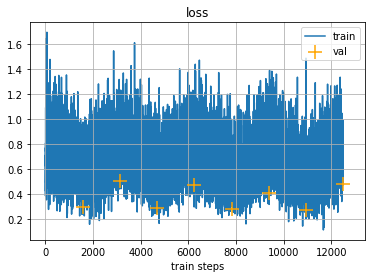

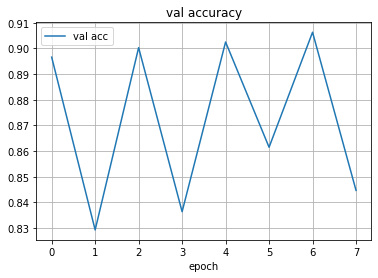

EPOCH 7:
Total time from start: 170.0min 58.506093978881836s
TRAIN: 20.0min 8.16677212715149s for epoch, mean loss = 0.6369042811976056
VAL: 1.0min 13.569295167922974s for epoch, mean loss = 0.48077418126713356, acc = 0.8446999788284302


In [7]:
predictions_ensemble1, test_labels, \
vgg16_cifar10_fge_1_acc, vgg16_cifar10_fge = train(vgg16_cifar10_fge, 
                                                   optimizer, 
                                                   criterion, 
                                                   dataset_loader_train, 
                                                   dataset_loader_test, 
                                                   8, 10, dir_name, C, a_1, a_2)

In [8]:
print('Ensemble 1 accuracy:', vgg16_cifar10_fge_1_acc)

Ensemble 1 accuracy: 0.9124


---

In [9]:
vgg16_cifar10_fge = models.vgg16_bn(pretrained=False, **{'num_classes' : 10})
vgg16_cifar10_fge.load_state_dict(torch.load('vgg16_cifar10_32ep_2.pt'))
vgg16_cifar10_fge = vgg16_cifar10_fge.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(vgg16_cifar10_fge.parameters(), lr=0.01, weight_decay=0.0005, momentum=0.9)
optimizer.load_state_dict(torch.load('vgg16_cifar10_32ep_2_opt.pt'))

C = 2
dir_name = 'vgg16_cifar10_fge_2'
a_1 = 0.01
a_2 = 0.0005

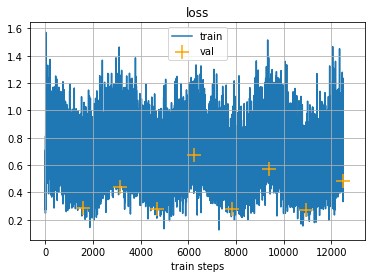

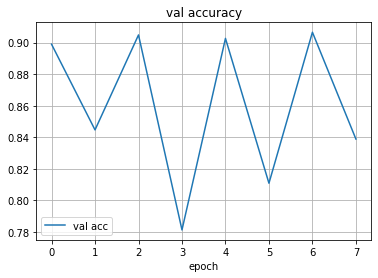

EPOCH 7:
Total time from start: 171.0min 13.06809401512146s
TRAIN: 20.0min 12.063782215118408s for epoch, mean loss = 0.6294928256396064
VAL: 1.0min 13.808618068695068s for epoch, mean loss = 0.48539537510361536, acc = 0.8388999700546265


In [10]:
predictions_ensemble2, test_labels, \
vgg16_cifar10_fge_2_acc, vgg16_cifar10_fge = train(vgg16_cifar10_fge, 
                                                   optimizer, 
                                                   criterion, 
                                                   dataset_loader_train, 
                                                   dataset_loader_test, 
                                                   8, 10, dir_name, C, a_1, a_2)

In [11]:
print('Ensemble 2 accuracy:', vgg16_cifar10_fge_2_acc)

Ensemble 2 accuracy: 0.9125


---

In [6]:
vgg16_cifar10_fge = models.vgg16_bn(pretrained=False, **{'num_classes' : 10})
vgg16_cifar10_fge.load_state_dict(torch.load('vgg16_cifar10_32ep_3.pt'))
vgg16_cifar10_fge = vgg16_cifar10_fge.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(vgg16_cifar10_fge.parameters(), lr=0.01, weight_decay=0.0005, momentum=0.9)
optimizer.load_state_dict(torch.load('vgg16_cifar10_32ep_3_opt.pt'))

C = 2
dir_name = 'vgg16_cifar10_fge_3'
a_1 = 0.01
a_2 = 0.0005

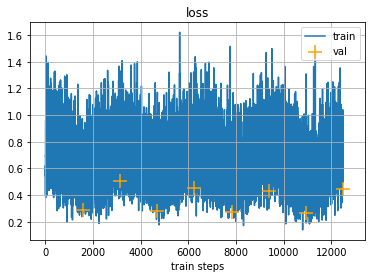

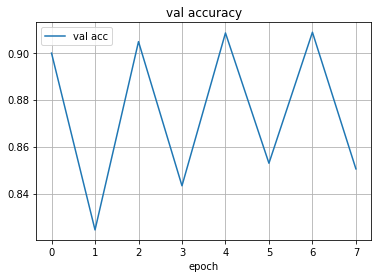

EPOCH 7:
Total time from start: 172.0min 9.856358528137207s
TRAIN: 20.0min 17.519541025161743s for epoch, mean loss = 0.6348118361512286
VAL: 1.0min 14.39761209487915s for epoch, mean loss = 0.44618468296032743, acc = 0.8504999876022339


In [7]:
predictions_ensemble3, test_labels, \
vgg16_cifar10_fge_3_acc, vgg16_cifar10_fge = train(vgg16_cifar10_fge, 
                                                   optimizer, 
                                                   criterion, 
                                                   dataset_loader_train, 
                                                   dataset_loader_test, 
                                                   8, 10, dir_name, C, a_1, a_2)

In [8]:
print('Ensemble 3 accuracy:', vgg16_cifar10_fge_3_acc)

Ensemble 3 accuracy: 0.9139


---

In [12]:
vgg16_cifar10_fge_1_2_acc = np.mean(np.argmax(predictions_ensemble1 + predictions_ensemble2, axis=1) == test_labels)
print('Ensemble 1 and 2 accuracy:', vgg16_cifar10_fge_1_2_acc)

Ensemble 1 and 2 accuracy: 0.9172


---

In [7]:
predictions_ensemble123 = np.zeros((len(dataset_loader_test.dataset), 10), dtype=np.float32)
targets10 = None
for i in range(3):
    for j in range(4):
        base_model = models.vgg16_bn(pretrained=False, **{'num_classes' : 10})
        base_model.load_state_dict(torch.load('vgg16_cifar10_fge_{}/base_model_{}.pt'.format(i + 1, j)))
        base_model = base_model.cuda()
        
        _, tmpacc, tmppreds, targets10 = val(base_model, dataset_loader_test, nn.CrossEntropyLoss())
        predictions_ensemble123 += tmppreds
        clear_output()
        
vgg16_cifar10_fge_1_2_3_acc = np.mean(np.argmax(predictions_ensemble123, axis=1) == targets10)
print('Ensemble 1, 2 and 3 accuracy:', vgg16_cifar10_fge_1_2_3_acc)

Ensemble 1, 2 and 3 accuracy: 0.9191


---

In [6]:
vgg16_cifar10_1 = models.vgg16_bn(pretrained=False, **{'num_classes' : 10})
vgg16_cifar10_1.load_state_dict(torch.load('vgg16_cifar10_40ep_1.pt'))

vgg16_cifar10_2 = models.vgg16_bn(pretrained=False, **{'num_classes' : 10})
vgg16_cifar10_2.load_state_dict(torch.load('vgg16_cifar10_40ep_2.pt'))

vgg16_cifar10_3 = models.vgg16_bn(pretrained=False, **{'num_classes' : 10})
vgg16_cifar10_3.load_state_dict(torch.load('vgg16_cifar10_40ep_3.pt'))

vgg16_cifar10_1, vgg16_cifar10_2, vgg16_cifar10_3 = vgg16_cifar10_1.cuda(), vgg16_cifar10_2.cuda(), vgg16_cifar10_3.cuda()

_, acc10_1, preds10_1, targets10 = val(vgg16_cifar10_1, dataset_loader_test, nn.CrossEntropyLoss())
_, acc10_2, preds10_2, targets10 = val(vgg16_cifar10_2, dataset_loader_test, nn.CrossEntropyLoss())
_, acc10_3, preds10_3, targets10 = val(vgg16_cifar10_3, dataset_loader_test, nn.CrossEntropyLoss())

In [7]:
print(acc10_1.item(), acc10_2.item(), acc10_3.item())

0.9086999893188477 0.9134999513626099 0.9158999919891357


In [9]:
ind2_ensemble_acc = np.mean(np.argmax(preds10_1 + preds10_2, axis=1) == targets10)
print('Ensemble (Ind, models 1 and 2) accuracy:', ind2_ensemble_acc)

Ensemble (Ind, models 1 and 2) accuracy: 0.9174


In [10]:
ind3_ensemble_acc = np.mean(np.argmax(preds10_1 + preds10_2 + preds10_3, axis=1) == targets10)
print('Ensemble (Ind, models 1, 2 and 3) accuracy:', ind3_ensemble_acc)

Ensemble (Ind, models 1, 2 and 3) accuracy: 0.9191


## VGG-16 on CIFAR100

In [5]:
data_transform_train = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_cifar100 = datasets.CIFAR100(root='cifar100/train', train=True, transform=data_transform_train, download=True)
test_cifar100 = datasets.CIFAR100(root='cifar100/test', train=False, transform=data_transform_test, download=True)

dataset_loader_train = torch.utils.data.DataLoader(train_cifar100, batch_size=32, shuffle=True, num_workers=4)
dataset_loader_test = torch.utils.data.DataLoader(test_cifar100, batch_size=32, shuffle=False, num_workers=4)

/anaconda/envs/py36/lib/python3.6/site-packages/torchvision/transforms/transforms.py:694: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")


Files already downloaded and verified
Files already downloaded and verified


In [6]:
vgg16_cifar100_fge = models.vgg16_bn(pretrained=False, **{'num_classes' : 100})
vgg16_cifar100_fge.load_state_dict(torch.load('vgg16_cifar100_32ep_1.pt'))
vgg16_cifar100_fge = vgg16_cifar100_fge.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(vgg16_cifar100_fge.parameters(), lr=0.01, weight_decay=0.0005, momentum=0.9)
optimizer.load_state_dict(torch.load('vgg16_cifar100_32ep_1_opt.pt'))

C = 2
dir_name = 'vgg16_cifar100_fge_1'
a_1 = 0.01
a_2 = 0.0005

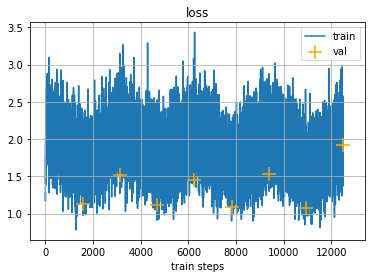

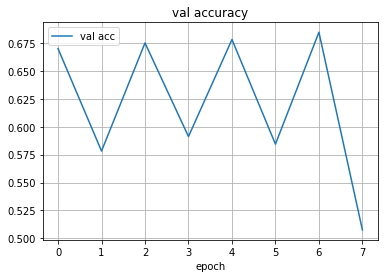

EPOCH 7:
Total time from start: 171.0min 45.607274293899536s
TRAIN: 20.0min 11.501412630081177s for epoch, mean loss = 1.7592425106125464
VAL: 1.0min 13.700392007827759s for epoch, mean loss = 1.9183277940978638, acc = 0.5074999928474426


In [7]:
predictions_ensemble1_100, test_labels100, \
vgg16_cifar100_fge_1_acc, vgg16_cifar100_fge = train(vgg16_cifar100_fge, 
                                                   optimizer, 
                                                   criterion, 
                                                   dataset_loader_train, 
                                                   dataset_loader_test, 
                                                   8, 100, dir_name, C, a_1, a_2)

In [8]:
print('Ensemble 1 accuracy:', vgg16_cifar100_fge_1_acc)

Ensemble 1 accuracy: 0.694


---

In [9]:
vgg16_cifar100_fge = models.vgg16_bn(pretrained=False, **{'num_classes' : 100})
vgg16_cifar100_fge.load_state_dict(torch.load('vgg16_cifar100_32ep_2.pt'))
vgg16_cifar100_fge = vgg16_cifar100_fge.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(vgg16_cifar100_fge.parameters(), lr=0.01, weight_decay=0.0005, momentum=0.9)
optimizer.load_state_dict(torch.load('vgg16_cifar100_32ep_2_opt.pt'))

C = 2
dir_name = 'vgg16_cifar100_fge_2'
a_1 = 0.01
a_2 = 0.0005

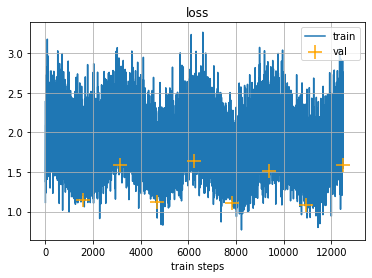

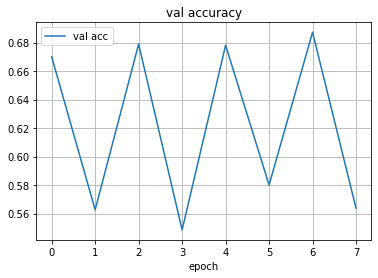

EPOCH 7:
Total time from start: 171.0min 18.618711948394775s
TRAIN: 20.0min 9.407592058181763s for epoch, mean loss = 1.7814391049450968
VAL: 1.0min 13.623309135437012s for epoch, mean loss = 1.5858911744321877, acc = 0.5637999773025513


In [10]:
predictions_ensemble2_100, test_labels100, \
vgg16_cifar100_fge_2_acc, vgg16_cifar100_fge = train(vgg16_cifar100_fge, 
                                                   optimizer, 
                                                   criterion, 
                                                   dataset_loader_train, 
                                                   dataset_loader_test, 
                                                   8, 100, dir_name, C, a_1, a_2)

In [11]:
print('Ensemble 2 accuracy:', vgg16_cifar100_fge_2_acc)

Ensemble 2 accuracy: 0.6933


---

In [10]:
vgg16_cifar100_fge = models.vgg16_bn(pretrained=False, **{'num_classes' : 100})
vgg16_cifar100_fge.load_state_dict(torch.load('vgg16_cifar100_32ep_3.pt'))
vgg16_cifar100_fge = vgg16_cifar100_fge.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(vgg16_cifar100_fge.parameters(), lr=0.01, weight_decay=0.0005, momentum=0.9)
optimizer.load_state_dict(torch.load('vgg16_cifar100_32ep_3_opt.pt'))

C = 2
dir_name = 'vgg16_cifar100_fge_3'
a_1 = 0.01
a_2 = 0.0005

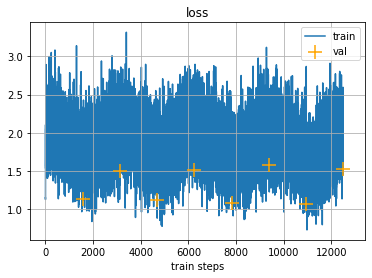

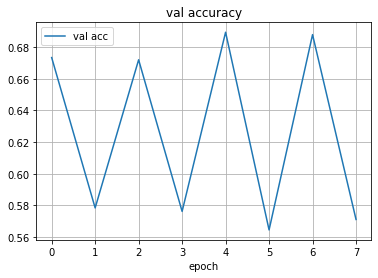

EPOCH 7:
Total time from start: 175.0min 45.760751485824585s
TRAIN: 20.0min 43.666372299194336s for epoch, mean loss = 1.7458852130636067
VAL: 1.0min 14.201838254928589s for epoch, mean loss = 1.534398859110884, acc = 0.5710999965667725


In [11]:
predictions_ensemble3_100, test_labels100, \
vgg16_cifar100_fge_3_acc, vgg16_cifar100_fge = train(vgg16_cifar100_fge, 
                                                   optimizer, 
                                                   criterion, 
                                                   dataset_loader_train, 
                                                   dataset_loader_test, 
                                                   8, 100, dir_name, C, a_1, a_2)

In [12]:
print('Ensemble 3 accuracy:', vgg16_cifar100_fge_3_acc)

Ensemble 3 accuracy: 0.6989


---

In [12]:
vgg16_cifar100_fge_1_2_acc = np.mean(np.argmax(predictions_ensemble1_100 + predictions_ensemble2_100, axis=1) == test_labels100)
print('Ensemble 1 and 2 accuracy:', vgg16_cifar100_fge_1_2_acc)

Ensemble 1 and 2 accuracy: 0.7052


---

In [6]:
predictions_ensemble123 = np.zeros((len(dataset_loader_test.dataset), 100), dtype=np.float32)
targets100 = None
for i in range(3):
    for j in range(4):
        base_model = models.vgg16_bn(pretrained=False, **{'num_classes' : 100})
        base_model.load_state_dict(torch.load('vgg16_cifar100_fge_{}/base_model_{}.pt'.format(i + 1, j)))
        base_model = base_model.cuda()
        
        _, tmpacc, tmppreds, targets100 = val(base_model, dataset_loader_test, nn.CrossEntropyLoss())
        predictions_ensemble123 += tmppreds
        clear_output()
        
vgg16_cifar100_fge_1_2_3_acc = np.mean(np.argmax(predictions_ensemble123, axis=1) == targets100)
print('Ensemble 1, 2 and 3 accuracy:', vgg16_cifar100_fge_1_2_3_acc)

Ensemble 1, 2 and 3 accuracy: 0.7108


---

In [7]:
vgg16_cifar100_1 = models.vgg16_bn(pretrained=False, **{'num_classes' : 100})
vgg16_cifar100_1.load_state_dict(torch.load('vgg16_cifar100_40ep_1.pt'))

vgg16_cifar100_2 = models.vgg16_bn(pretrained=False, **{'num_classes' : 100})
vgg16_cifar100_2.load_state_dict(torch.load('vgg16_cifar100_40ep_2.pt'))

vgg16_cifar100_3 = models.vgg16_bn(pretrained=False, **{'num_classes' : 100})
vgg16_cifar100_3.load_state_dict(torch.load('vgg16_cifar100_40ep_3.pt'))

vgg16_cifar100_1, vgg16_cifar100_2, vgg16_cifar100_3 = vgg16_cifar100_1.cuda(), vgg16_cifar100_2.cuda(), vgg16_cifar100_3.cuda()

_, acc100_1, preds100_1, targets100 = val(vgg16_cifar100_1, dataset_loader_test, nn.CrossEntropyLoss())
_, acc100_2, preds100_2, targets100 = val(vgg16_cifar100_2, dataset_loader_test, nn.CrossEntropyLoss())
_, acc100_3, preds100_3, targets100 = val(vgg16_cifar100_3, dataset_loader_test, nn.CrossEntropyLoss())

In [8]:
print(acc100_1.item(), acc100_2.item(), acc100_3.item())

0.6940999627113342 0.6953999996185303 0.6960999965667725


In [9]:
ind2_ensemble_acc = np.mean(np.argmax(preds100_1 + preds100_2, axis=1) == targets100)
print('Ensemble (Ind, models 1 and 2) accuracy:', ind2_ensemble_acc)

Ensemble (Ind, models 1 and 2) accuracy: 0.7051


In [10]:
ind3_ensemble_acc = np.mean(np.argmax(preds100_1 + preds100_2 + preds100_3, axis=1) == targets100)
print('Ensemble (Ind, models 1, 2 and 3) accuracy:', ind3_ensemble_acc)

Ensemble (Ind, models 1, 2 and 3) accuracy: 0.7107
